# **Progetto di Introduzione All'Apprendimento Automatico**
### *a.a. 2023/2024*


# Deblurring di immagini mosse

Il progetto riguarda il deblurirng di immagini. Il tipo di "blur" in questione è ottenuto mediante sovrapposizione di immagini leggermente traslate a partire dall'originale, lungo un tragitto randomico.

Questo tipo di blur intende simulare il risultato del tremolio della mano per riprese con tempo di esposizione prolungato.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

In [ ]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


In [ ]:
my_gen = generator(x_train,5)

In [ ]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

5


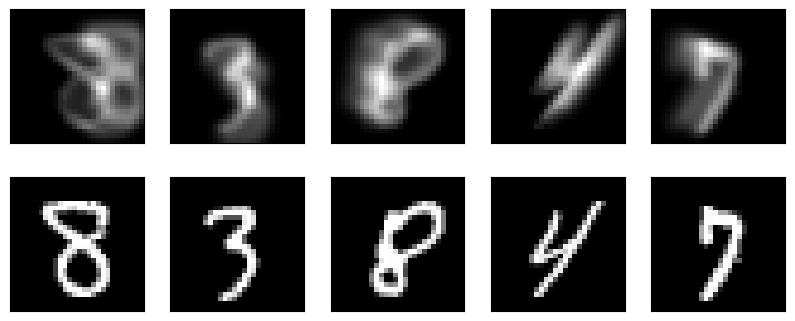

In [ ]:
test_x,test_y = next(my_gen)
plot(test_x,test_y)



# DEBLURRING DI IMMAGINI MOSSE: **Unet**
## Motivazioni della scelta
Per la risoluzione del problema di deblurring di immagini mosse ho deciso di implementare un autoencoder, nello specifico una Unet.
Tale architettura è particolarmente efficiente nel nostro caso, poiché Unet è progettata per task di segmentazione e denoising delle immagini che condividono analogie con il nostro problema di deblurring.<br>
La forma a U della nostra rete permette di mantenere informazioni durante l'encoding e di recuperarle durante l'operazione di concatenazione nel decoding.
Questa caratteristica è utile nel caso si voglia eseguire una ricostruzione dettagliata di un'immagine, come nel deblurring.

## Architettura della mia rete
### Encoder
Questa fase è composta da una serie di strati convolutivi, batch normalization, activation e max-pooling intesi per ridurre progressivamente la dimensione spaziale dell'input e aumentare la profondità delle caratteristiche.
È composta da due blocchi che rispettivamente utilizzano 64 e 128 filtri.
### Bottleneck
Qui è presente un solo blocco che utilizza 256 filtri ed è composto da due strati convolutivi, batch normalization e activation.
### Decoder
Il decoder, terminando lo schema ad U, presenta due blocchi.
Essi percepiscono le caratteristiche dell'encoder attraverso la concatenazione e introducendo le skip connections che permettono di recuperare ulteriori dettagli che avremmo perso altrimenti.
I blocchi utilizzano 128 e 64 filtri e al loro interno eseguono l'operazione di upsampling che ripristina le dimensioni dell'input.
Implementano anche i layer convolutivi, batch normalization e activation.

### Layer SCSE (*Spatial and Channel 'Squeeze & Excitation'*)
Dopo varie prove empiriche ho aggiunto i blocchi SCSE alla mia Unet.
Un blocco SCSE è un blocco che enfatizza le informazioni importanti delle feature e sopprime quelle non importanti.
Tale comportamento è utile per migliorare la segmentazione semantica.<br>
Ho inserito i blocchi SCSE alla fine dei layer convolutivi di tutti i miei blocchi, quindi nell'encoder, bottleneck e decoder.
Il ratio delle scse è stato scelto sempre in base a delle prove relative alle performance del modello nel training.

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Activation, Concatenate, Conv2DTranspose, GlobalAveragePooling2D, Reshape, Dense, multiply, BatchNormalization

def scse_block(input_tensor, ratio=8):
    # Squeeze
    squeeze = GlobalAveragePooling2D()(input_tensor)
    squeeze = Reshape((1, 1, input_tensor.shape[-1]))(squeeze)

    # Excitation
    excitation = Dense(input_tensor.shape[-1] // ratio, activation='relu')(squeeze)
    excitation = Dense(input_tensor.shape[-1], activation='sigmoid')(excitation)

    # Scale
    scaled = multiply([input_tensor, excitation])

    return scaled

def down_block(inputs, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = BatchNormalization()(conv)

    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = BatchNormalization()(conv)

    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = BatchNormalization()(conv)

    conv = Activation(activation)(conv)

    conv = scse_block(conv)

    pool = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv, pool

def up_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    up = UpSampling2D(size=(2, 2))(inputs)
    concat = Concatenate()([up, skip])

    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(concat)
    conv = BatchNormalization()(conv)

    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = BatchNormalization()(conv)

    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = BatchNormalization()(conv)

    conv = Activation(activation)(conv)


    conv = scse_block(conv)

    return conv

def bottleneck(inputs, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    conv = Conv2D(filters, kernel_size, padding=padding, activation=activation)(inputs)
    conv = BatchNormalization()(conv)

    conv = Conv2D(filters, kernel_size, padding=padding, activation=activation)(conv)
    conv = BatchNormalization()(conv)

    conv = Activation(activation)(conv)

    conv = scse_block(conv)

    return conv

def unet(img_size=(28, 28, 1), num_classes=1):
    inputs = Input(shape=img_size)

    # Encoder
    conv1, pool1 = down_block(inputs, 64)
    conv2, pool2 = down_block(pool1, 128)

    # Bottleneck
    conv3 = bottleneck(pool2, 256)

    # Decoder
    conv4 = up_block(conv3, conv2, 128)
    conv5 = up_block(conv2, conv1, 64)

    # Output layer
    outputs = Conv2D(num_classes, (1, 1), activation='relu')(conv5)

    model = Model(inputs=inputs, outputs=outputs, name="unet")
    return model

# Shape
HEIGHT, WIDTH = 28, 28 #MNIST shape
# Classi
NUM_CLASSES = 1 # scala di grigi

model = unet(img_size=(HEIGHT, WIDTH, 1), num_classes=NUM_CLASSES)

model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 28, 28, 64)           640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_14 (Ba  (None, 28, 28, 64)           256       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_16 (Conv2D)          (None, 28, 28, 64)           36928     ['batch_normalization_14[0]

# Iperparametri e allenamento della rete
Il learning rate (0,001) e l'ottimizzatore usato (Adam) sono stati frutto di una serie di sperimentazioni della combinazione di essi unitamente ad alcuni parametri della rete come la dimensione dei kernel utilizzati nel modello (tutti (3x3)).<br>
La rete adotta anche un learning rate scheduler che dimezza il valore del learning rate ogni 5 epoche.
La decisione del valore degli iperparametri è stata principalmente influenzata dalla media della mse, loss, val_loss e dalle metriche che ho utilizzato per valutare la performance del mio modello durante l'addestramento, tra cui l'accuracy, precision, recall e f1 score.<br>
Le epoche totali (15) e il batch size (25) sono tali per cui si evita overfitting massimizzando loss e val_loss, nel mentre minimizzando il tempo impiegato per il training.
Ogni epoca impiega poco più di 30s a terminare con T4 GPU impostata come hardware su Colab.

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, AUC
precision = Precision()
recall = Recall()
def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * (precision_val * recall_val) / (precision_val + recall_val + 1e-10)  # Aggiungo 1e-20 per evitare divisione per zero


from tensorflow.keras.callbacks import LearningRateScheduler
#LR scheduler
def lr_schedule(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr = lr * 0.5  # Learning rate dimezzato ogni 5 epoche
    return lr

# Callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Compilo il modello
LEARNING_RATE = 0.001
METRICS = ["accuracy",precision,recall,f1_score]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="mse",
    metrics=METRICS,
)

# Generator
SIZE = 10000
(x_train_gen, y_train_gen) = next(generator(x_train, 60000))
(x_test_gen,y_test_gen) = next(generator(x_test, SIZE))

# Addestramento del modello
EPOCHS = 15
BATCH_SIZE = 25
history = model.fit(
    x_train_gen,
    y_train_gen,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[lr_scheduler]
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
1920/1920 [==============================] - 50s 21ms/step - loss: 0.0114 - accuracy: 0.8105 - precision_1: 0.9705 - recall_1: 0.6689 - f1_score: 0.7444 - val_loss: 0.0053 - val_accuracy: 0.8143 - val_precision_1: 0.9898 - val_recall_1: 0.6969 - val_f1_score: 0.8170 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/15
1920/1920 [==============================] - 37s 19ms/step - loss: 0.0044 - accuracy: 0.8138 - precision_1: 0.9930 - recall_1: 0.6876 - f1_score: 0.8124 - val_loss: 0.0043 - val_accuracy: 0.8146 - val_precision_1: 0.9921 - val_recall_1: 0.6980 - val_f1_score: 0.8189 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/15
1920/1920 [==============================] - 38s 20ms/step - loss: 0.0035 - accuracy: 0.8141 - precision_1: 0.9951 - recall_1: 0.6877 - f1_score: 0.8134 - val_loss: 0.

# Valutazione

## MSE e Deviazione standard
- La media finale dell'MSE su 10 round vale: 0.0017835531616583467<br>
- La deviazione standard vale: 2.5258217647206038e-05<br>

Tali valori sono calcolati sul modello finale addestrato con 15 epoche e ultima epoca con le seguenti metriche:
- loss: 0.0012
- accuracy: 0.8148
- precision: 0.9999
- recall: 0.6898
- f1_score: 0.8164
- val_loss: 0.0018
- val_accuracy: 0.8155
-  val_precision: 0.9987
- val_recall: 0.6856
- val_f1_score: 0.8125




Vengono inoltre riportati i grafici relativi alla MSE nei 10 round, il grafico tra loss e val_loss e il valore dell'indice SSIM che è pari a 0.9879504049447039, tale indice rappresenta la similità strutturale tra l'immagine del mio modello e quella della ground truth.





313/313 [==============================] - 3s 9ms/step
Media MSE su 10 round: 0.0017835531616583467
Deviazione Standard MSE su 10 round: 2.5258217647206038e-05
SSIM: 0.9879504049447039


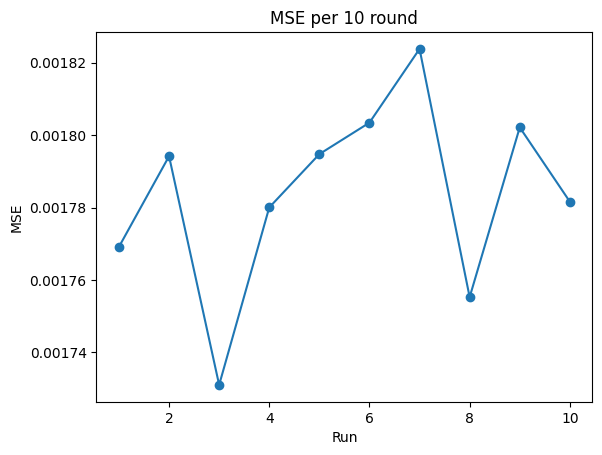

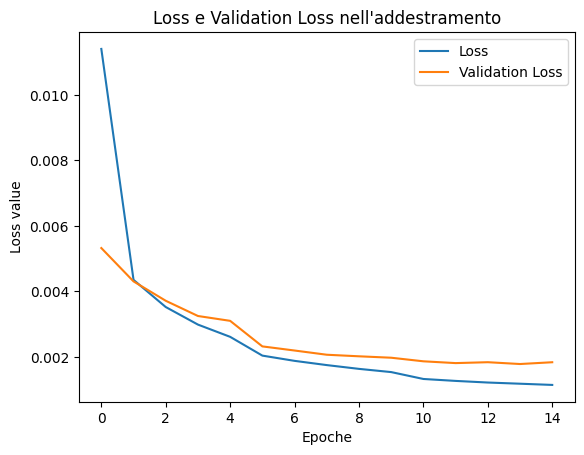

In [ ]:
# Valutazione del modello

from skimage import metrics

predict_output = model.predict(x_test_gen)

# Se ho meno di 20 immagini le plotto per avere un risultato visivo
if(SIZE<=20):
    plot(predict_output,y_test_gen)
    plot(x_test_gen,y_test_gen)


mse_calculator = tf.keras.losses.MeanSquaredError()
mse_scores = []
ssim = 0;

ROUND = 10 # 10 round

for i in range(ROUND):
    test_x,test_y = next(generator(x_test,10000))
    subset = model.predict(test_x)
    test_y = tf.expand_dims(test_y, axis=-1)

    #MSE
    mse = mse_calculator(test_y,subset).numpy() #mse del round
    #print(mse)
    mse_scores.append(mse) #aggiungo mse del round all'array

    #Altre metriche
    test_y_squeeze = tf.squeeze(test_y).numpy()
    subset_squeeze = tf.squeeze(subset).numpy()

    ssim += metrics.structural_similarity(test_y_squeeze, subset_squeeze) #ssim



# Calcolo della media dell'MSE e della deviazione standard
mean_mse = np.mean(mse_scores)
std_dev = np.std(mse_scores)

# Media MSE e deviazione standard
print(f'Media MSE su {ROUND} round: {mean_mse}')
print(f'Deviazione Standard MSE su {ROUND} round: {std_dev}')

# Altre metriche
print(f"SSIM: {ssim / ROUND}")


# Plot di tutte le MSE nei 10 round
runs = np.arange(1, ROUND+1)
plt.plot(runs, mse_scores, marker='o')
plt.xlabel('Run')
plt.ylabel('MSE')
plt.title(f'MSE per {ROUND} round')
plt.show()


# Estrai le metriche dal training history
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

# Plot della Train Loss e Validation Loss
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoche')
plt.ylabel('Loss value')
plt.legend()
plt.title('Loss e Validation Loss nell\'addestramento')
plt.show()
